# Ensemble from Dataquest

https://www.dataquest.io/blog/introduction-to-ensembles/

In [67]:
import numpy as np
import pandas as pd
import psycopg2 as pg
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

In [69]:
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

In [70]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

In [71]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [72]:
conn.close()

In [73]:
target = 'Outcome'
features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']

In [74]:
rows_to_drop = (np.isnan(df_approach2Combined_training.Outcome)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.AvgRank)) | (np.isnan(df_approach2Combined_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_training.WinPct)) | (np.isnan(df_approach2Combined_training.OpponentWinPct)) | (np.isnan(df_approach2Combined_training.WinPctDiff)) | (np.isnan(df_approach2Combined_training.AvgPointsFor)) | (np.isnan(df_approach2Combined_training.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.TourWins)) | (np.isnan(df_approach2Combined_training.OpponentTourWins)) | (np.isnan(df_approach2Combined_training.TourWinsDiff))

In [75]:
df_approach2Combined_training = df_approach2Combined_training.drop(df_approach2Combined_training[rows_to_drop].index)

In [76]:
rows_to_drop = (np.isnan(df_approach2Combined_dev.Outcome)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.AvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.WinPct)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.TourWins)) | (np.isnan(df_approach2Combined_dev.OpponentTourWins)) | (np.isnan(df_approach2Combined_dev.TourWinsDiff))

In [77]:
df_approach2Combined_dev = df_approach2Combined_dev.drop(df_approach2Combined_dev[rows_to_drop].index)

In [78]:
xtrain = df_approach2Combined_training[features]
ytrain = df_approach2Combined_training[target]
xtest = df_approach2Combined_dev[features]
ytest = df_approach2Combined_dev[target].astype(int)

In [79]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [80]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    #svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {#'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

In [81]:
base_learners = get_models()

In [82]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

In [83]:
from mlens.ensemble import SuperLearner

In [84]:
# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

In [85]:
# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)


Fitting 2 layers
Processing layer-1             done | 00:07:33
Processing layer-2             done | 00:01:40
Fit complete                        | 00:09:14

Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:04


In [86]:
print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Super Learner ROC-AUC score: 0.811



Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:04


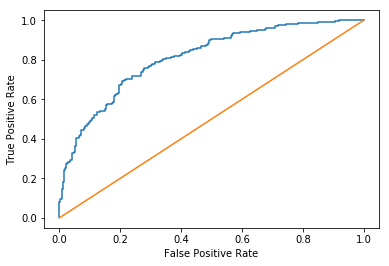

In [87]:
y_probas = sl.predict_proba(xtest)

fpr, tpr, thresholds = metrics.roc_curve(ytest, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [88]:
# Determine log-loss
print 'Log loss: {}'.format(log_loss(ytest, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(ytest, y_probas[:,1]))

Log loss: 0.536426812235
RMSE: 0.18113516221
